[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)

# Agent

## 復習

ルーターを作りました。

* チャットモデルは、ユーザ入力に基づいて、ツールを呼び出すかどうかを決定します。
* 条件付きエッジを使って、ツールを呼び出すノードまたはendノードにルーティングします。

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## ゴール

復習の内容を一般的なエージェントアーキテクチャに拡張することができます。

上記のルータでは、モデルを呼び出し、ツールを呼び出すことを選択した場合、ユーザに `ToolMessage` を返しました。

しかし、単純に `ToolMessage` を *モデルに渡す* としたらどうでしょうか？

(1)別のツールを呼び出すか、(2)直接応答することができます。

これが一般的なエージェントアーキテクチャである[ReAct](https://react-lm.github.io/)の直感的理解です。

* `act` - モデルに特定のツールを呼び出させます。
* `observe` - ツールの出力をモデルに戻します。
* `reason` - 次に何をすべきかを決定するために、モデルにツールの出力を推論させます（例えば、別のツールを呼び出すか、単に直接応答するか）。

この[汎用アーキテクチャ](https://blog.langchain.dev/planning-for-agents/)は多くの種類のツールに適用できます。

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [1]:
import os
import getpass


def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

ここでは[実行結果の追跡](https://docs.smith.langchain.com/concepts/tracing)に[LangSmith](https://docs.smith.langchain.com/)を使います。

`langchain-academy`というプロジェクトにログを記録します。


In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [3]:
from langchain_openai import ChatOpenAI


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o-2024-08-06")
llm_with_tools = llm.bind_tools(tools)

LLMを作成し、全体的なエージェントの期待通りの動作をさせてみましょう。

In [5]:
from langchain_core.messages.base import BaseMessage
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")


# Node
def assistant(state: MessagesState) -> dict[str, list[BaseMessage]]:
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

先ほどと同じように `MessagesState` を使い、ツールのリストを含む `Tools` ノードを定義します。

`Assistant` ノードは、単にツールをバインドしたモデルです。

`Assistant` ノードと `Tools` ノードでグラフを作成します。

このエッジは `Assistant` がツールを呼び出すかどうかに基づいて `End` または `Tools` にルーティングします。

ここで、新しいステップを1つ追加します：

`Tools`ノードを`Assistant`に*戻して*、ループを形成します。

* `assistant`ノードが実行された後、`tools_condition`はモデルの出力がツールコールであるかどうかをチェックします。
* もしツールコールであれば、フローは `tools` ノードに向かいます。
* `tools` ノードは `assistant` に接続します。
* このループはモデルがツールを呼び出すことを決定する限り続きます。
* モデルの応答がツール呼び出しでない場合、フローは END ノードに送られ、処理を終了します。



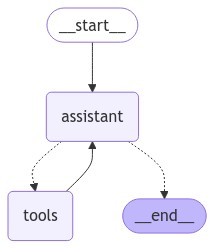

In [7]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [10]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_P3LkCVktXyUZP7GSp2l6hA2N)
 Call ID: call_P3LkCVktXyUZP7GSp2l6hA2N
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_k5OJRKJWQmWyrTKYhZvDj6z7)
 Call ID: call_k5OJRKJWQmWyrTKYhZvDj6z7
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_7DkAukwoCeovjRxH4XXLmy5n)
 Call ID: call_7DkAukwoCeovjRxH4XXLmy5n
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

## LangSmith

We can look at traces in LangSmith.